In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32  # Define the batch size
desired_size = (224, 224)

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2  # Using 20% of data for validation
# )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


# Adjust the directory paths to the preprocessed dataset
train_generator = train_datagen.flow_from_directory(
    directory='dataset',
    target_size=desired_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    directory='dataset',
    target_size=desired_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle= False
)


Found 7246 images belonging to 2 classes.
Found 1811 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile

# Load the pre-trained MobileNetV3 Small model without the top layer
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent it from being updated during the first phase of training
base_model.trainable = False

# Add custom layers on top of the MobileNetV3 Small base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce feature maps to a single vector per map
x = Dense(1024, activation='relu')(x)  # Dense layer with relu activation
x = Dropout(0.3)(x)  # Dropout for regularization
x = Dense(512, activation='relu')(x)  # Additional dense layer with relu activation
x = Dropout(0.2)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)  # Additional dense layer with relu activation
x = Dropout(0.1)(x)  # Dropout for regularization
predictions = Dense(2, activation='softmax')(x)  # Final output layer with softmax for 2 classes


# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Set the initial learning rate
initial_learning_rate = 0.001

# Compile the model
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()






Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']      

In [12]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_sofar_nasnetmobile.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)  # Adjust these parameters
# Unfreeze some top layers of the base model
base_model.trainable = True
fine_tune_at = 100  # This is an example value; adjust based on your model's architecture
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Adjust learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
model.fit(
    train_generator,
    epochs=10,  # Adjust based on your needs
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Save the trained model with the '.keras' extension
model.save('nasnetmobile_finetuned_model.keras')


Epoch 1/10
227/227 [==============================] - 397s 2s/step - loss: 0.1335 - accuracy: 0.9459 - val_loss: 0.5262 - val_accuracy: 0.8509 - lr: 1.0000e-05
Epoch 2/10
227/227 [==============================] - 336s 1s/step - loss: 0.1265 - accuracy: 0.9522 - val_loss: 0.5132 - val_accuracy: 0.8526 - lr: 1.0000e-05
Epoch 3/10
227/227 [==============================] - 337s 1s/step - loss: 0.1136 - accuracy: 0.9547 - val_loss: 0.5354 - val_accuracy: 0.8642 - lr: 1.0000e-05
Epoch 4/10
227/227 [==============================] - 334s 1s/step - loss: 0.1084 - accuracy: 0.9543 - val_loss: 0.5228 - val_accuracy: 0.8675 - lr: 1.0000e-05
Epoch 5/10
227/227 [==============================] - 322s 1s/step - loss: 0.1014 - accuracy: 0.9603 - val_loss: 0.5886 - val_accuracy: 0.8498 - lr: 1.0000e-05
Epoch 5: early stopping


In [13]:
from tensorflow.keras.models import load_model

# Assuming your model is saved under 'best_model.keras'
model = load_model('best_model_sofar_nasnetmobile.keras')


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32  # Adjust to your preference
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory='test_dataset_processed',
    target_size=(224, 224),  # Ensure this matches your model's expected input
    batch_size=batch_size,
    class_mode='categorical',  # or 'binary' for binary classification
    shuffle=False  # Important for confusion matrix
)


Found 1090 images belonging to 2 classes.


In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


35/35 [==============================] - 15s 249ms/step - loss: 0.4658 - accuracy: 0.8560
Test Loss: 0.46579089760780334
Test Accuracy: 0.8559632897377014


35/35 [==============================] - 12s 244ms/step


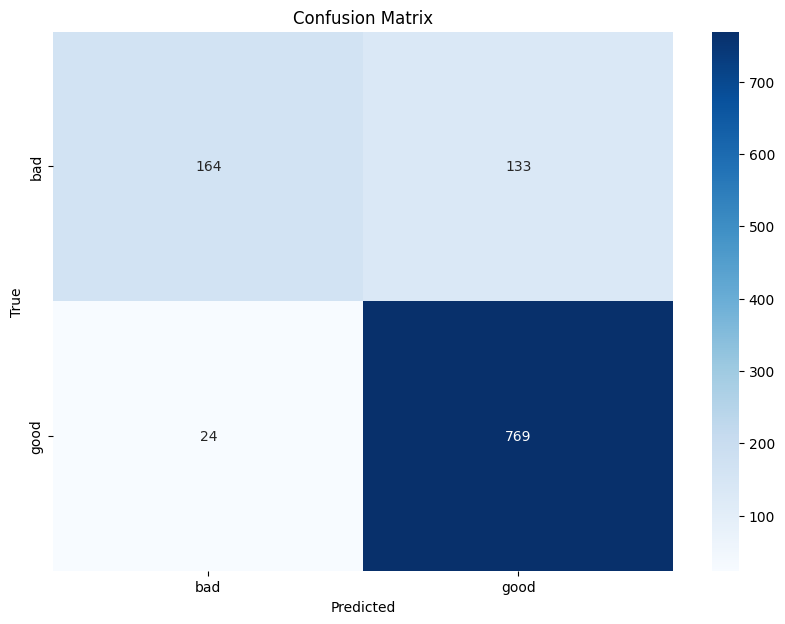

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


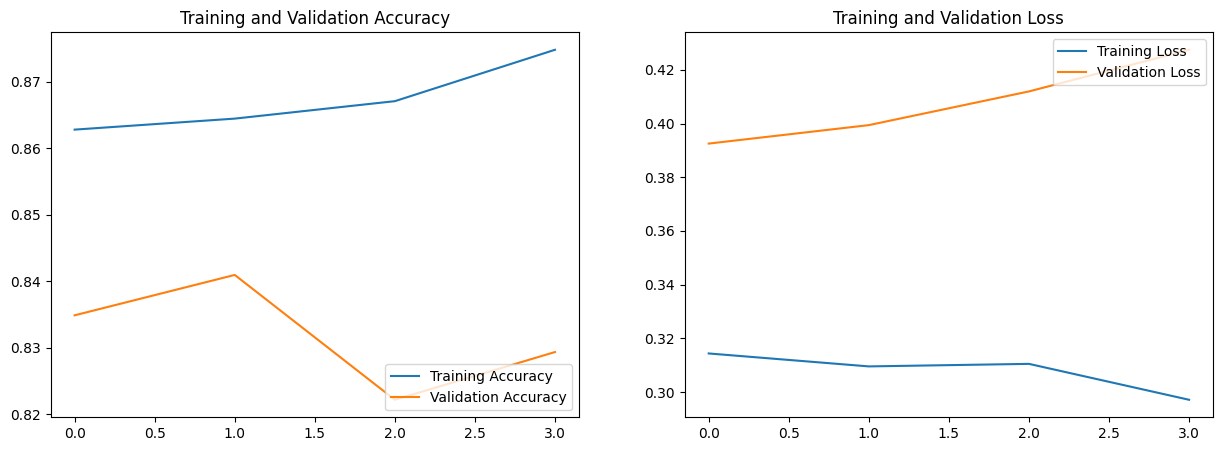

In [17]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Assuming 'history' is the return value from model.fit()
plot_training_history(history)


1/1 [==============================] - 0s 56ms/step


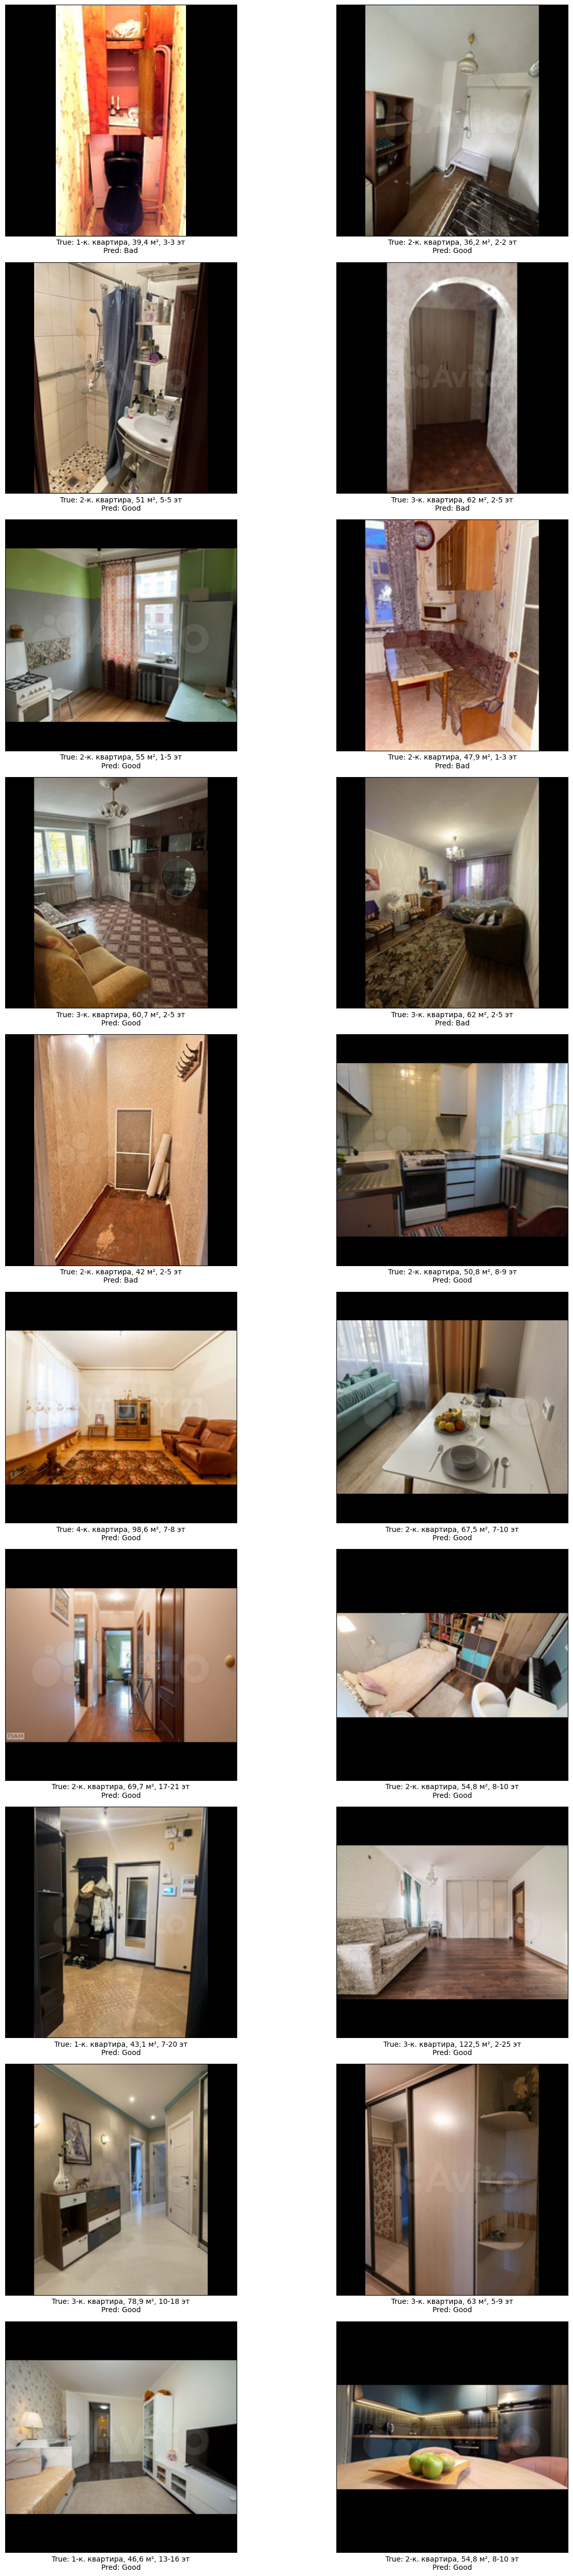

In [19]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming the model is saved and can be loaded
model = load_model('best_model_sofar_nasnetmobile.keras')

def load_and_prepare_image(image_path, target_size=(224, 224)):
    """Load an image from file and prepare it for prediction."""
    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0  # Scale image
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

def predict_and_display_images_from_folders(base_path, model, num_images=10):
    """Automatically select and display predictions for images from test dataset folders."""
    categories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    selected_images = []
    for category in categories:
        # Fetch all png images from all subdirectories of the category
        image_paths = glob.glob(os.path.join(base_path, category, '**', '*.png'), recursive=True)
        if not image_paths:
            print(f"No images found in {os.path.join(base_path, category)}. Skipping this category.")
            continue
        # Ensure there are enough images to select from
        num_to_select = min(num_images // len(categories), len(image_paths))
        selected_images.extend(np.random.choice(image_paths, size=num_to_select, replace=False))

    plt.figure(figsize=(15, num_images // 2 * 5))
    for i, image_path in enumerate(selected_images):
        image = load_and_prepare_image(image_path)
        prediction = model.predict(image)
        predicted_class = np.argmax(prediction, axis=1)[0]
        true_label = os.path.basename(os.path.dirname(image_path))  # This gets the immediate parent directory name

        plt.subplot(len(selected_images) // 2, 2, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(image), cmap='gray')
        plt.xlabel(f"True: {true_label}\nPred: {'Good' if predicted_class == 1 else 'Bad'}")
    plt.tight_layout()
    plt.show()

# Path to your test dataset
test_dataset_path = 'test_dataset_processed'
predict_and_display_images_from_folders(test_dataset_path, model, num_images=20)
